In [16]:
from keras.layers import Input, Conv2D, Lambda, MaxPool2D, UpSampling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dense, Add, Multiply, BatchNormalization, Dropout, concatenate
from keras.models import Model
from keras import backend as K
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
X_train = np.load("lib/datasets/X_train_bb.npy")
X_val = np.load("lib/datasets/X_test_bb.npy")
y_train = np.load("lib/datasets/y_train_e_bb.npy")
y_val = np.load("lib/datasets/y_test_e_bb.npy")

In [20]:
y_train.shape

(4113,)

In [3]:
from lib.models import AlexNet

In [4]:
model = AlexNet(X_train.shape[1:], 47).build_model()
model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1,
    mode='max', min_delta=0.0001, cooldown=2, min_lr=0)
epochs = 50
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks = [callback])

Epoch 1/50
197/197 [==============================] - 17s 61ms/step - loss: 3.0078 - accuracy: 0.2078 - val_loss: 3.1942 - val_accuracy: 0.2451 - lr: 0.0010
Epoch 2/50
197/197 [==============================] - 10s 51ms/step - loss: 2.7583 - accuracy: 0.2532 - val_loss: 2.8130 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 3/50
197/197 [==============================] - 10s 51ms/step - loss: 2.6304 - accuracy: 0.2807 - val_loss: 2.5554 - val_accuracy: 0.3049 - lr: 0.0010
Epoch 4/50
197/197 [==============================] - 10s 51ms/step - loss: 2.5019 - accuracy: 0.3051 - val_loss: 2.3288 - val_accuracy: 0.3405 - lr: 0.0010
Epoch 5/50
197/197 [==============================] - 10s 50ms/step - loss: 2.3695 - accuracy: 0.3369 - val_loss: 2.1957 - val_accuracy: 0.3927 - lr: 0.0010
Epoch 6/50
197/197 [==============================] - 10s 51ms/step - loss: 2.2507 - accuracy: 0.3676 - val_loss: 2.0601 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 7/50
197/197 [==============================] - 10s 

197/197 [==============================] - 10s 51ms/step - loss: 0.2570 - accuracy: 0.9087 - val_loss: 0.3527 - val_accuracy: 0.8612 - lr: 1.0000e-05


In [6]:
model.save("lib/models/AlexNet_bb")

INFO:tensorflow:Assets written to: lib/models/AlexNet_bb\assets


In [1]:
from keras.layers import Input, Conv2D, Lambda, MaxPool2D, UpSampling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dense, Add, Multiply, BatchNormalization, Dropout, concatenate
from keras.models import Model
from keras import backend as K
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

In [2]:
alex = tf.keras.models.load_model("lib/models/AlexNet_bb")
X_train = np.load("lib/datasets/X_train_bb.npy")
X_val = np.load("lib/datasets/X_test_bb.npy")
y_train = np.load("lib/datasets/y_train_e_bb.npy")
y_val = np.load("lib/datasets/y_test_e_bb.npy")
z_train = np.load("lib/datasets/z_train_bb.npy")
z_val = np.load("lib/datasets/z_test_bb.npy")
alex = Model(inputs=alex.input, outputs=alex.layers[-7].output)
alex.trainable = False

In [3]:
alex.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 zero_padding2d (ZeroPadding  (None, 31, 31, 96)       0         
 2D)                                                             
                                                             

In [3]:
flatten = alex.output
flatten = Flatten()(flatten)
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# softmaxHead = Dense(512, activation="relu")(flatten)
# softmaxHead = Dropout(0.5)(softmaxHead)
# softmaxHead = Dense(512, activation="relu")(softmaxHead)
# softmaxHead = Dropout(0.5)(softmaxHead)
# softmaxHead = Dense(47, activation="softmax",name="class_label")(softmaxHead)
model = Model(inputs=alex.input,outputs=bboxHead)

In [4]:
# losses = {"class_label": "sparse_categorical_crossentropy","bounding_box": "mean_squared_error",}
# lossWeights = {"class_label": 1.0,"bounding_box": 1.0
# }
# opt = 'Adam'
import tensorflow.keras.backend as K
def iou_loss(y_true, y_pred):
    # iou loss for bounding box prediction
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    # loss for the iou value
    iou_loss = -K.log(iou)

    return iou_loss
def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou  
model.compile(loss=iou_loss, optimizer='adam', metrics=[iou_metric])

In [5]:
model.save("lib/models/bb_test")

INFO:tensorflow:Assets written to: lib/models/bb_test\assets


In [1]:
from keras.layers import Input, Conv2D, Lambda, MaxPool2D, UpSampling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dense, Add, Multiply, BatchNormalization, Dropout, concatenate
from keras.models import Model
from keras import backend as K
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

In [ ]:
def iou_loss(y_true, y_pred):
    # iou loss for bounding box prediction
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    # loss for the iou value
    iou_loss = -K.log(iou)

    return iou_los

In [2]:
model = tf.keras.models.load_model("lib/models/bb_test")
X_train = np.load("lib/datasets/X_train_bb.npy")
X_val = np.load("lib/datasets/X_val_bb.npy")
y_train = np.load("lib/datasets/y_train_e_bb.npy")
y_val = np.load("lib/datasets/y_val_e_bb.npy")
z_train = np.load("lib/datasets/z_train_bb.npy")
z_val = np.load("lib/datasets/z_val_bb.npy")

ValueError: Unknown loss function: iou_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [3]:
yz_train = {"class_label": y_train,"bounding_box": z_train
}
yz_test = {"class_label": y_val,"bounding_box": z_val
}

In [18]:
y_train.shape

(4113,)

In [6]:
history = model.fit(X_train, z_train, validation_data=(X_val, z_val), batch_size=32, epochs=30, verbose=1)

Epoch 1/30
197/197 [==============================] - 15s 35ms/step - loss: 1.2731 - iou_metric: 0.2809 - val_loss: 1.2791 - val_iou_metric: 0.2786
Epoch 2/30
197/197 [==============================] - 5s 25ms/step - loss: 1.2760 - iou_metric: 0.2795 - val_loss: 1.2791 - val_iou_metric: 0.2786
Epoch 3/30
197/197 [==============================] - 5s 25ms/step - loss: 1.2760 - iou_metric: 0.2795 - val_loss: 1.2791 - val_iou_metric: 0.2786
Epoch 4/30
197/197 [==============================] - 5s 25ms/step - loss: 1.2760 - iou_metric: 0.2795 - val_loss: 1.2791 - val_iou_metric: 0.2786
Epoch 5/30
197/197 [==============================] - 5s 24ms/step - loss: 1.2760 - iou_metric: 0.2795 - val_loss: 1.2791 - val_iou_metric: 0.2786
Epoch 6/30
197/197 [==============================] - 5s 24ms/step - loss: 1.2760 - iou_metric: 0.2795 - val_loss: 1.2791 - val_iou_metric: 0.2786
Epoch 7/30
197/197 [==============================] - 5s 24ms/step - loss: 1.2760 - iou_metric: 0.2795 - val_loss: 1.

KeyboardInterrupt: 

In [5]:
model.save("lib/models/bb")

INFO:tensorflow:Assets written to: lib/models/bb\assets


In [7]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import cv2 as cv

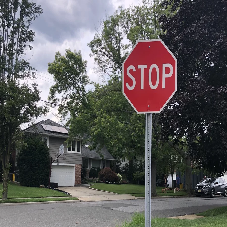

In [9]:
x=load_img('sample.jpg',target_size=(227,227))
x

In [10]:
x=img_to_array(x)/255.0
x=np.expand_dims(x,axis=0)

In [11]:
preds=model.predict(x)
preds

array([[0.32193938, 0.40375465, 0.33821994, 0.45158234]], dtype=float32)

In [12]:
x1,y1,x2,y2=preds[0]

In [18]:
x1 * 227, y1 * 227, x2 * 227, y2 * 227

(73.08023902773857, 91.65230590105057, 76.77592653036118, 102.50919172167778)

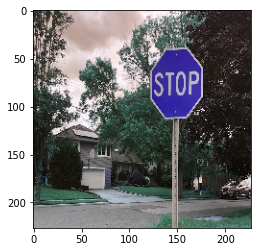

In [26]:
i = x * 255.0
i = i.astype("int32")
i = i.reshape((227, 227, 3))
startx, starty, endx, endy = int(x1 * 227), int(y1 * 227), int(x2 * 227), int(y2 * 227)
cv2.rectangle(i, (startX, startY), (endX, endY),(0, 255, 0), 2)
plt.imshow(i[:,:,::-1])

In [27]:
startx, starty, endx, endy

(73, 91, 76, 102)

(675, 900, 3)


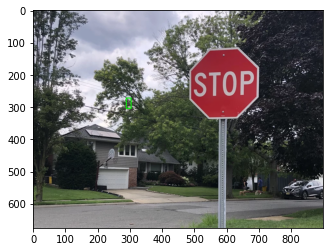

In [20]:
image = cv2.imread('sample.jpg')
#image = imutils.resize(image, width=700)
(h,w) = image.shape[:2]
print(image.shape)
startX = int(x1 * w)
startY = int(y1 * h)
endX = int(x2* w)
endY = int(y2* h)
# draw the predicted bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
# show the output image
plt.imshow(image[:,:,::-1])